# ECM3420: Learning From Data - Coursework 2 Clustering


Candidate Number: 020891



# Task 1
Task 1 was to write a function to complete K-Means Clustering upon a dataset. Although a specific function signature was requested, I made the deicision to add another parameter: y. This parameter is optional and as it is not positional, it does not change the specified usage of the function. However, it is useful for allowing us to take the centroids that are produced by the function and make predicitions for unseen data points.

Another approach that would allow for us to keep the same signature as specified in the coursework would be to, similar to the approach that SkLearn takes, to create a class for handling the clustering. This would allow us to access the centroids at a later point and predict new data without the 'y' parameter. I chose not to take this approach, however, as I feel this departs further still from the specification.


In [157]:
import numpy as np
from math import sqrt


class Centroid:
    """Data structure for holding a Centroid.

    Initialise with a unique label and a numpy array as a value. 

    Attributes:
        label: The label assigned to the centroid.

        initial_value: Numpy array representing the centroid of all data points associated with this centroid

        __points_count: Private integer keeping track of the number of points asssociated with this centroid

    """

    def __init__(self, label, initial_value):
        self.value = initial_value
        self.label = label
        self.__points_count = 0


    def __str__(self):
        return f"Centroid({self.label} of value {self.value})"


    def calculate_value(self, data_point, removing=True):
        """Calculate the value of a centroid based on current value and new datapoint.

        Args:
            data_point: Numpy array representing data-point being added/removed

            removing: Boolean that determines whether data_point should be add to or
                      removed from centroid value. (Default=True)
        
        Returns:
            Numpy array representing the new value of a centroid

        """
        
        # Undo mean division of value to get total of all data points
        new_value = self.value * self.__points_count

        # If we are adding the point
        if not removing:        
            # Recalculate average with new point added
            new_value += data_point.value
            self.__points_count += 1
        else:
            # Recalculate average with old point removed
            new_value -= data_point.value
            self.__points_count -= 1

        self.value = new_value / self.__points_count
        return new_value


class DataPoint:
    """Data structure for a datapoint with a centroid association.

    Attributes:
        value: Numpy array holding the datapoint's value

        centroid: Centroid instance representing the datapoint's currently associated centroid

    """

    def __init__(self, value):
        self.value = value
        self.centroid = None


    def __str__(self):
        return f"DataPoint({self.value} of centroid {self.centroid})"


    def assign_to_nearest_centroid(self, centroids):
        """Assigns the datapoint to its nearest centroid from a list of given centroids.

        Args:
            centroids: List of centroids

        Returns:
            (old_centroid, new_centroid)
                old_centroid: The previous centroid associated with the value. Note that for the initial iteration, this will be None

                new_centroid: The newly assigned centroid. Note that as centroids converge, this could be the same as old_centroid

        """
        flag_first = True
        
        min_distance = 0
        min_centroid = None

        old_centroid = self.centroid

        for centroid in centroids:
            distance = euclidian_distance(self.value, centroid.value)
            # Initialise minimum value
            if flag_first:
                flag_first = False
                min_distance = distance
                min_centroid = centroid
                pass
            
            # Update minimum distance and centroid
            if distance < min_distance:
                min_distance = distance
                min_centroid = centroid
        
        self.centroid = min_centroid
        
        return old_centroid, self.centroid


# ------------------------------------ #
#                 UTILS                #
# ------------------------------------ #
def euclidian_distance(point1, point2):
    """Calculate the euclidian distance between two points.

    Args:
        point1: Numpy array representing the first point

        point2: Numpy array representing the second point
    
    Returns:
        Float value of the euclidian distance between point1 and point2

    """
    return sqrt(sum(np.square(point2 - point1)))


def initialise(x, k):
    """Initialise DataPoints and Centroids for K-Means-Clustering.

    Create a list of DataPoint objects based on the points in x. 
    Initialise k Clusters, each with a random point as a starting value.
    
    Args:
        x: A list of datapoints

        k: The number of centroids to initialise
    
    Returns:
        centroids: A list of initialised Centroids

        data_points: A list of initialised DataPoints

    """
    # Create a DataPoint instance for each datapoint in x then form a list of these
    data_points = [DataPoint(dp) for dp in x]

    # Randomly choose k points to initialise as clusters
    random_points_indices = np.random.choice(len(data_points), size=k)
    
    # Fetch the DataPoint instances that correspond to the random indices
    initial_centroid_points = [data_points[index] for index in random_points_indices]

    # Create a list of centroids initialised with the DataPoint values above. Assign a unique label to each
    centroids = [Centroid(label=i, initial_value=c.value) for i, c in enumerate(initial_centroid_points)]

    return centroids, data_points    


def fit_points(data_points, centroids):
    """Estimate labels for a set of data_points according to a set of existing clusters.

    Args:
        data_points: A list of numpy arrays representing data points.

        centroids: A list of Centroid instances 

    Returns:
        data_labels: A list consisting of labels for each data point

    """
    # Initialise test data points
    data_points = [DataPoint(dp) for dp in data_points]

    # Assign to their nearest centroid
    for data_point in data_points:
        data_point.assign_to_nearest_centroid(centroids)
    
    # Return a list of each data point's label
    return [data_point.centroid.label for data_point in data_points]


def incremental_kmeans(x, k, y=None, max_itr=100, random_state=None):
    """Run incremental K-Means Clustering on a dataset.

    Runs incremental K-Means Clustering on a dataset. Returns a list of datapoint cluster labels 
    and the number of iterations taken. 

    Args:
        x: A list consisting of numpy arrays as datapoints

        k: The number of clusters to find

        max_itr: The maximum number of iterations to run before ending iteration. Default=100

        random_state: Integer value used to seed the randomness for deterministic behaviour. Default=None

        y: A list consisting of test data. Labels will be determined and returned.

    Returns:
        cluster_labels: A list consisting of each datapoint's cluster association

        iter_count: The number of iterations the K-Means Clustering ran.

        If y is given:
            y_labels: A list consisting of each test datapoint's cluster association

    """
    # Seed the randomness if a value is provided.
    if random_state is not None:
        np.random.seed(random_state)
    
    # Initialise centroids and data points from x and k
    centroids, data_points = initialise(x, k)

    # Initial iteration, assigning points to their initial centroids
    for point in data_points:
        point.assign_to_nearest_centroid(centroids)

    
    flag_stop = False
    iter_count = 0

    while not flag_stop:
        iter_count += 1
        flag_stop = True

        for point in data_points:
            # Retrieve the old and new centroid assignments for the current point
            old_centroid, new_centroid = point.assign_to_nearest_centroid(centroids)    
            
            # In the first iteration, a point will not have an old centroid so we need this check
            if old_centroid is not None:
                old_centroid.calculate_value(point, removing=True)

            new_centroid.calculate_value(point)

            # A centroid has changed so we should continue iterating
            if old_centroid is not new_centroid:
                flag_stop = False

        if iter_count >= max_itr:
            print("Ended having reached maximum iterations")
            flag_stop = True
    
    x_cluster_labels = [data_point.centroid.label for data_point in data_points]

    # If y is given, predict labels for datapoints in y
    if y is not None:

        y_cluster_labels = fit_points(y, centroids)

        return x_cluster_labels, iter_count, y_cluster_labels
        
    return x_cluster_labels, iter_count

# Task 2
Note that all tables in this courseworks should be viewed on the live notebook. Sadly, exporting to PDF does not maintain HTML tables such as the ones that this question produces.

In [158]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
import time


dataset = load_iris().data

# Dictionaries to hold results. Key = K Value
inc_times = {2: [], 3: [], 4: [], 5: []}
inc_iters = {2: [], 3: [], 4: [], 5: []}

std_times = {2: [], 3: [], 4: [], 5: []}
std_iters = {2: [], 3: [], 4: [], 5: []}

# Where we are just evaluating speed / performance here, there is no point
# splitting the data into training and testing data. 
for m in range(5):
    for k in range(2, 6):
        time_start = time.time()
        iters = incremental_kmeans(dataset, k)[1]
        time_end = time.time()
        
        inc_times[k].append(time_end-time_start)
        inc_iters[k].append(iters)

        time_start = time.time()
        kmeans = KMeans(n_clusters=k).fit(dataset)
        time_end = time.time()

        std_times[k].append(time_end-time_start)
        std_iters[k].append(kmeans.n_iter_)

       


In [210]:
from tabulate import tabulate
from IPython.display import HTML, display


def avg_results(results):
    """Convert a list of lists to a list of averages.

    Converts a list of lists to a list of averages. Each inner list is reduced down to
    its average and added to the return list at the corresponding position.

    Args:
        results: A list of lists, each list containing numbers
    
    Returns:
        The list of averages

    """
    averages = [(sum(row)/len(row)) for row in results.values()]
    return averages


def display_time_iterations_table(time1, iter1, time2, iter2):
    """Draws a table showing the average times and iterations of the two K-Means methods.

    Args:
        time1: The results from testing Incremental K-Means runtime

        iter1: The results from testing Incremental K-Means Iteration counts

        time2: The results from testing Standard K-Means runtime

        iter2: The results from testing Standard K-Means Iteration counts

    """
    row1 = ["", "", "K=2", "K=3", "K=4", "K=5"]
    row2 = ["Inc K-Means", "Average Time"] + avg_results(time1)
    row3 = ["", "Average Iterations"] + avg_results(iter1)
    
    row4 = ["Std K-Means", "Average Time"] + avg_results(time2)
    row5 = ["", "Average Iterations"] + avg_results(iter2)
    display(HTML(tabulate([row1, row2, row3, row4, row5], tablefmt="html")))

# Display the results formatted above in HTML
display_time_iterations_table(inc_times, inc_iters, std_times, std_iters)
print("fig1: Table showing comparisons in average run-times and iterations between standard and incremental K-Means as K changes")

,,K=2,K=3,K=4,K=5
Inc K-Means,Average Time,0.006389093399047851,0.009797477722167968,0.013193702697753907,0.02079482078552246
,Average Iterations,3.2,4.0,4.6,6.4
Std K-Means,Average Time,0.01161661148071289,0.018004369735717774,0.020005035400390624,0.021800470352172852
,Average Iterations,3.6,4.8,3.4,11.0


fig1: Table showing comparisons in average run-times and iterations between standard and incremental K-Means as K changes


fig2: Boxplot showing the distribution of runtimes of Incremental K-Means Clustering for each value of K


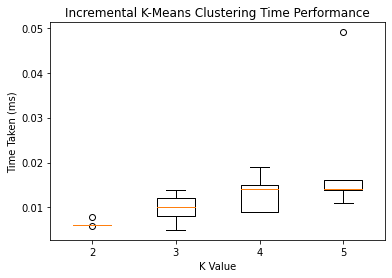

In [212]:
import matplotlib.pyplot as plt 
%matplotlib inline

fig, ax = plt.subplots()
ax.set_title("Incremental K-Means Clustering Time Performance")
ax.set_xlabel("K Value")
ax.set_ylabel("Time Taken (ms)")
ax.boxplot(inc_times.values(), positions=list(inc_times.keys()))
print("fig2: Boxplot showing the distribution of runtimes of Incremental K-Means Clustering for each value of K")

# Task 3

In [161]:
def jaccard_score_cw2(y_true, y_pred):
    """Calculate the jaccard score for a set of true versus predicted labels

    Args:
        y_true: The list of true labels for each datapoint

        y_pred: The list of labels predicted by a model

    Returns:
        The jaccard score of the predicted labels
        
    """
    a = b = 0

    for i in range(len(y_true)):

        for j in range(i+1, len(y_true)): 
            # If it is SS, add to a        
            if y_true[i] == y_true[j] and y_pred[i] == y_pred[j]:
                a += 1
            # Else, if it is not DD, add it to the denominator
            elif not(y_true[i] != y_true[j] and y_pred[i] != y_pred[j]):
                b += 1    

    return a/(a+b)

# Task 4
When evaluating the performance of Standard K-Means against Incremental K-Means, I chose to split the data into training and testing sets. This is important to do when measuring how well a model has worked because it prevents overfitting.

Overfitting of data is when a model becomes very effective at categorising data that it has seen before, to the deteriment of its performance with data that it has not seen. The model is trained on the training set of data. This data is used to find the values for the clusters. The test data (which we have labels for) is then categorised according to its closest cluster. Finally, we can compare the label predicted to the truth to get a good understanding of how accurate the categorisation has been.

In [239]:
from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split

iris_data = load_iris()

# Split data into test and train
X_train, X_test, y_train, y_test = train_test_split(iris_data.data, iris_data.target, train_size=0.7)

# Run incremental method with training data to get predicted y labels
incremental_labels = incremental_kmeans(x=X_train, k=3, y=X_test)[2]

# Train KMeans on training data, then predict test labels
kmeans = KMeans(n_clusters=3).fit(X_train)
standard_labels = kmeans.predict(X_test)


def display_jaccard_results_comparison(y_test, incremental_labels, standard_labels):
    """Displays a table comparing the jaccard scores of incremental and standard K-Means Clustering

    Args:
        y_test: The truth labels for each datapoint
        
        incremental_labels: The labels predicted by incremental K-Means

        standard_labels: The labels produced by standard K-Means

    """
    row1 = ["", "Coursework Jaccard", "SkLearn Jaccard"]

    row2 = [
        "Incremental K-Means",
        jaccard_score_cw2(y_test, incremental_labels),
        jaccard_score(y_test, incremental_labels, average='weighted')
    ]

    row3 = [
        "Standard K-Means",
        jaccard_score_cw2(y_test, standard_labels),
        jaccard_score(y_test, standard_labels, average='weighted')
    ]

    display(HTML(tabulate([row1, row2, row3], tablefmt="html")))


def display_cluster_labels(method, truth_labels, cluster_labels, labels_count=3):
    """Displays a table showing the number of points of each label assigned to each centroid.

    Args:
        method: The name of the method as a string to act as a table header.

        truth_labels: A list consisting of true labels for each datapoint

        cluster_labels: A list consisting of the cluster associations for each datapoint. 

        labels_count: The number of possible labels. Note that labels should be 0 <= l <= labels_count

    """
    results = np.zeros((labels_count, labels_count))

    for label, cluster in zip(truth_labels, cluster_labels):
        results[cluster][label] += 1
    
    row1 = [method, "Label 1", "Label 2", "Label 3"]
    row2 = ["Cluster 1"] + list(results[0])
    row3 = ["Cluster 2"] + list(results[1])
    row4 = ["Cluster 3"] + list(results[2])

    display(HTML(tabulate([row1, row2, row3, row4], tablefmt="html")))

display_jaccard_results_comparison(y_test, incremental_labels, standard_labels)
print("fig3: Comparison of the outputs of our Jaccard Score against SkLearn's Jaccard Score.")


display_cluster_labels("Inc. K-Means", y_test, incremental_labels)
print("fig4: Confusion-matrix-like table showing the count of each label's association with each cluster for Incremental K-Means")
display_cluster_labels("Std. K-Means", y_test, standard_labels)
print("fig5: Confusion-matrix-like table showing the count of each label's association with each cluster for Standard K-Means")


,Coursework Jaccard,SkLearn Jaccard
Incremental K-Means,0.7225,0.8357323232323233
Standard K-Means,0.6859296482412061,0.81002331002331


fig3: Comparison of the outputs of our Jaccard Score against SkLearn's Jaccard Score.


Inc. K-Means,Label 1,Label 2,Label 3
Cluster 1,15.0,1.0,0.0
Cluster 2,0.0,18.0,3.0
Cluster 3,0.0,0.0,8.0


fig4: Confusion-matrix-like table showing the count of each label's association with each cluster for Incremental K-Means


Std. K-Means,Label 1,Label 2,Label 3
Cluster 1,15.0,0.0,0.0
Cluster 2,0.0,17.0,3.0
Cluster 3,0.0,2.0,8.0


fig5: Confusion-matrix-like table showing the count of each label's association with each cluster for Standard K-Means


fig6: Barchart showing the average time differences between Standard and Incremental K-Means as K changes


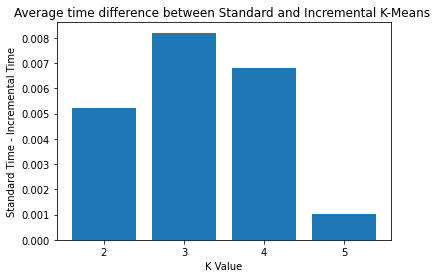

In [215]:
# Plot average time difference against number of clusters
avg_inc_times = np.array(avg_results(inc_times))
avg_std_times = np.array(avg_results(std_times))

avg_difference = avg_std_times - avg_inc_times

plt.bar([2, 3, 4, 5], avg_difference)
plt.title("Average time difference between Standard and Incremental K-Means ")
plt.xticks([2, 3, 4, 5])
plt.xlabel("K Value")
plt.ylabel("Standard Time - Incremental Time");
print("fig6: Barchart showing the average time differences between Standard and Incremental K-Means as K changes")

## Analysis
There are two main aspects to consider when comparing the Incremental and K-Means Clustering methods: Run-time performance and model effectiveness.

### Run-time performance
There is a trade-off to be had between Standard and Incremental K-Means. Iterations will take longer for Incremental K-Means as each can cluster is recalculated multiple times per iteration. However, the result of these extra calculations are that clusters tend to converge faster on their final value. This means that fewer iterations are required. 

In practice, my results show that this trade-off tends to favour Incremental K-Means. As fig1 shows, Incremental K-Means Clustering always takes less time than Standard K-Means. It is worth noting though that, as fig6 shows, this difference seems to become less pronounced as the value of K increases, despite the difference in iterations growing. It is possible that for greater numbers of clusters, the balance will change to favour Standard K-Means clustering. This would make sense as more clusters allows for more of the extra calculations that Incremental K-Means Clustering results in.

### Model effectiveness
To evaluate each model's correctness, we can look at their Jaccard Scores and the Confusion Matrices I have produced. As discussed in the introduction to this task, I have split the data into Test and Training data before evaluating each model to prevent over-fitting biasing my results. 

In fig3, we can see that both models perform well. Incremental has a marginally larger score. This is reinforced by comparing fig3 and fig4. Both methods get a very similar numbers of associations between a label's datapoints and centroid assignments. The names given to centroids will differ between each model as these are determined arbitrarily. 

It is also worth noting that, in repeating the experiment, it seems very changable which algorithm will perform better. They often produce the same confusion matrices and jaccard scores. 

### Conclusion
In conclusion, the difference is classification effectiveness seems negligable between the two methods. Both algorithms perform well with the iris dataset. Instead, the key repeatable difference seems to be in run-time performance. In this case, Incremental K-Means holds a larger advantage for smaller values of K. As K increases, standard becomes more competitive. This pattern will likely increase until standard overtakes incremental. It should be said, however, that the differences in iterations and run-times are very slight in real terms. Perhaps exploring with a much larger dataset would yield a greater difference in results.

